<a href="https://colab.research.google.com/github/PondKann/CXR-Project/blob/main/Score_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### import

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import cv2
import numpy as np
import pandas as pd
from torchsummary import summary
from skimage.io import imread, imsave
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import PIL
from PIL import Image


In [2]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import datasets, layers, models

from imutils import paths
import argparse

from sklearn.model_selection import KFold
from sklearn import metrics
from scipy.stats import zscore


import matplotlib.image as mpimg
from matplotlib.pyplot import savefig

import itertools
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

#### Load data // KKU

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/My Drive/Senior Project/CXR Image3class/Image'

train 3 class

In [ ]:
Normal151_dir = os.path.join(data_dir,'Normal151')
TB150_dir = os.path.join(data_dir,'TB150')
CA150_dir = os.path.join(data_dir,'CA150')

All_3class_dir = os.path.join(data_dir,'All_3class')

#### Load data // Gmail

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_dir = '/content/drive/My Drive/Senior Project/CXR Image3class'

train 3 class

In [5]:
Normal151_dir = os.path.join(data_dir,'Normal151')
TB150_dir = os.path.join(data_dir,'TB150')
CA150_dir = os.path.join(data_dir,'CA150')

All_3class_dir = os.path.join(data_dir,'All_3class')

# ส่วนใหม่

In [3]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

In [4]:
image = '/content/tb12.jpg'

In [5]:
image = load_img('/content/plastic.jpg', target_size= (224,224))
img = img_to_array(image)

In [6]:
img.shape

(224, 224, 3)

In [7]:
img = np.expand_dims(img, axis=0)

In [8]:
img.shape

(1, 224, 224, 3)

In [9]:
from keras.applications.vgg16 import preprocess_input

In [10]:
img = preprocess_input(img)

In [11]:
img.shape

(1, 224, 224, 3)

In [12]:
img

array([[[[-55.939003  ,   0.22100067, -57.68      ],
         [-50.939003  ,   5.2210007 , -52.68      ],
         [-41.939003  ,  15.221001  , -44.68      ],
         ...,
         [-63.939003  , -14.778999  , -75.68      ],
         [-80.939     , -28.779     , -90.68      ],
         [-35.939003  ,  16.221     , -45.68      ]],

        [[-43.939003  ,  12.221001  , -45.68      ],
         [-49.939003  ,   6.2210007 , -51.68      ],
         [-34.939003  ,  22.221     , -37.68      ],
         ...,
         [-38.939003  ,  13.221001  , -48.68      ],
         [-52.939003  ,  -1.7789993 , -60.68      ],
         [-31.939003  ,  19.221     , -39.68      ]],

        [[-40.939003  ,  15.221001  , -42.68      ],
         [-41.939003  ,  14.221001  , -43.68      ],
         [-12.939003  ,  44.221     , -15.68      ],
         ...,
         [-59.939003  ,  -8.778999  , -67.68      ],
         [-23.939003  ,  26.221     , -30.68      ],
         [-22.939003  ,  27.221     , -29.68      ]],

In [13]:
plt.imshow(image)

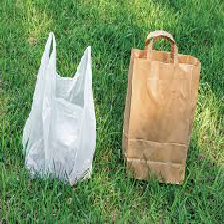

In [14]:
image

In [15]:
model = tf.keras.applications.VGG16(weights="imagenet")

In [16]:
pred = model.predict(img)

In [17]:
from keras.applications.imagenet_utils import decode_predictions
print( "predict", decode_predictions(pred, top=5)[0])

predict [('n03958227', 'plastic_bag', 0.5561434), ('n03709823', 'mailbag', 0.17960724), ('n04026417', 'purse', 0.04383272), ('n04204238', 'shopping_basket', 0.043442283), ('n03482405', 'hamper', 0.016519293)]


In [18]:
target = np.argmax(pred, axis=1).item()
print(target)

728


In [19]:
layer_outputs = model.layers[-6].output    # layer สุดท้าย เป็น output 
activation_model = Model(inputs=model.input, outputs=layer_outputs)

In [34]:
layer_outputs.shape

TensorShape([None, 14, 14, 512])

In [36]:
p = [2,5,6,9,7,8,5,1,2,3,6,4]
p[-4:]

[2, 3, 6, 4]

In [ ]:
maps2 = model.layers[-6].output

In [ ]:
maps = model.layers[-6].output    # 6 layer สุดท้าย เป็น output 

In [ ]:
maps.shape

In [29]:
# from numpy.core.fromnumeric import resize
from skimage.transform import resize
def upsample(input_shape, image):
    input_width = input_shape[0]
    input_height = input_shape[1]
    image = resize(image,( input_width, input_height), preserve_range = True )
    return image

In [ ]:
upsampled_activations = []
for x in range(512):
    upsampled_activations.append(upsample([224,224], layer_outputs[0,:,:,x]))

In [31]:
upsampled_activations = np.array(upsampled_activations)
upsampled_activations.shape

In [ ]:
normalized_activations = []
for n in range(upsampled_activations.shape[0]):
    for x in range(224):
        for y in range(224):

            normalized_activations.append(upsampled_activations[n,x,y]/
                                          ((np.max(upsampled_activations[n,:,:])-np.min(upsampled_activations[n,:,:]))+1e-5))
             

In [ ]:
input_2 = []
